# Practical 8: Text Mining

### In this practical
1. [Loading text data](#load)
2. [Data preprocessing](#prep)
3. [Document analysis](#analyse)
3. [Feature selection and transformation](#transform)

---
**Written by Hendi Lie (h2.lie@qut.edu.au) and Richi Nayak (r.nayak@qut.edu.au). All rights reserved.**

This practical introduces you to text document analysis and mining using Python.
Python is a programming language that supports widely used text libraries such
as NLTK and gensim for performing many common text mining tasks. You will learn how to preprocess text data, perform dimensionality reduction and cluster text documents based on their content. The text analysis problem covered in this
tutorial is **unlabelled**, however, supervised/predictive text mining problems are just as common.

## 1. Loading Text Data

The dataset for this practical is **Federalistpapers.json**, containing 85 news articles selected from a number of newspapers. The objective is to group these articles based on their content similarity. These clusters can then be further used for many purposes, such as recommending similar articles to readers according to query similarity.

As the dataset is in `.json` format, instead of the usual `.csv`, load the dataset using `.load_json` function from pandas.

In [1]:
import pandas as pd

# load the dataset
df = pd.read_json('datasets/Federalistpapers.json')

# random state
rs = 42

# as usual, explore the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85 entries, 0 to 9
Data columns (total 11 columns):
Attribution    85 non-null object
Author         85 non-null object
Filtered       85 non-null object
ID             85 non-null float64
Name           85 non-null object
Size           85 non-null int64
Target         73 non-null float64
Text           85 non-null object
Title          85 non-null object
Truncated      85 non-null float64
Unfiltered     85 non-null object
dtypes: float64(3), int64(1), object(7)
memory usage: 8.0+ KB


There are a number of columns in this dataset, covering information like ID, author, name, etc. As our aim is to discern articles based on their content, we need to inspect the `Text` column, which contains full text of each news article.

Get the text of the first document using `.get_value()` function and print out
the first 200 characters (can change the character size to to your liking).

In [2]:
# print out the first 200 characters of the first row of text column
print(df.get_value(index=0, col='Text')[:200])

To the People of the State of New York: AFTER an unequivocal experience of the inefficiency of the subsisting federal government, you are called upon to deliberate on a new Constitution for the United


On average, the `Text` column contains more than 13,000 characters. In this practical, we will be working with only 85 documents. However, in most text mining projects, you will deal many more documents, resulting in very large dataset and a lot of noise. This is particularly challenging in the era of social media and big data.

In [3]:
# average length of text column
print(df['Text'].apply(lambda x: len(x)).mean())

13279.30588235294


## 2. Data Prepocessing

Different from the structured tabular datasets that we have been working until
this practical, text data is considered as unstructured data. Text data requires significant preprocessing and transformation to make it a suitable training data for machine learning algorithms. There are a number of different methods to represent text data depending on the need and objective of the data mining process, including **bag of words**, **word2vec** and **sequential labels**. This practical will focus on the bag of words representation.

In the bag of words method, each individual document is split into tokens (a process called tokenisation). A token can be a single word, stemmed (or lemmatised) word, or multiple consecutive words (also called as N-gram). There are many preprocessing methods typically used in tokenisation, and we will be using the following techniques:
1. **Lowercase**: cast each word into its lowercased version. Ensure differently capitalised words are treated as the same word.
2. **Punctuation** removal: remove all punctuation marks. We are only interested at the words.
3. **Part of speech** filtering: keep tokens with certain part-of-speech only. In particular, here we are interested in adjectives, adverbs, nouns and verbs.
4. **Lemmatisation**: reducing words/tokens into their base form. 

> #### Lemmatisation vs stemming
>   There are minor diffrences between Lemmatisation and **stemming** that was
>   introduced in the lecture. Stemming usually refers to a heuristic process
>   that chops off the ends of words to get the base forms of the words.
>   Lemmatisation usually refers the process of doing similar things, but using
>   additional information of how the word is used in the context (semantic
>   information). Lemmatisation returns the dictionary form of a word, also
>   known as lemma. Given the word "ponies" for example, stemming will return
>   "poni" (incorrect), while lemmatisation will return "pony" (correct). The
>   drawback of lemmatisation is it requires additional analysis to obtain the
>   required semantic information.
>   [Source](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)

The next step is to transform the extracted tokens into a matrix structure, with documents as rows and tokens as columns. Each cell is a statistical value of a token in the corresponding document. This statistical value can range from simply whether the token is present in the document (0/1, binary), the frequency of appearances, document frequency, or other more complex calculations (TF-IDF, BM25, etc). TF-IDF is explained in detail in the lecture.

To perform all of these operations, we need the `nltk` library, which comes by default in Anaconda. Verify that it is indeed installed by opening your Anaconda prompt, running the iPython console and typing `import nltk` into the interpreter.

In additional to the library, we will need to download a number of packages in `nltk`. If this is your first time doing this tutorial, you also need to download certain packages in nltk. Follow these steps:
1. Open your anaconda prompt, type and run `ipython`.
2. Import nltk by typing `import nltk`.
3. Run `nltk.download()`.
4. A graphical window interface will open. Go to `All Packages` tab and download `WordNet`, `punkt`, `averaged_perceptron` and `stopwords` package.

Once you have done these steps, import the following modules from nltk.

In [4]:
import string

from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag

Before implementing preprocessing steps discussed earlier, we need to initialise a number of different resources.
1. **Lemmatizer**: Lemmatizers are pre-trained dictionaries that maps words and their semantic values into their lemma form. This practical will use WordNet lemmatizer, which takes English words and their part of speech tags as inputs. We will also implement the `lemmatize` function to help streamline the lemmatisation process.
2. **Stopwords**: List of common words that does not add any value into the analytical process, hence they need to be filtered out from the dataset. Common stopwords including *a, an, and*, *the,* and *is*. Each dataset also includes its own common words that should be treated as stopwords. Both `nltk` and `sklearn` provide a list of common stopwords for English. Additionally, `Federaliststop.json` includes domain-specific stopwords that should be excluded in the analysis. Therefore, we will merge the default NLTK stopword list with the provided stopwords.
3. **Punctuation**: List of string punctuations (",", ".", etc) that are not useful for text content analysis.

In [5]:
# initialise WordNet lemmatizer and punctuation filter
lemmatizer = WordNetLemmatizer()
punct = set(string.punctuation)

# load the provided stopwords
df_stop = pd.read_json('datasets/Federaliststop.json')

# join provided stopwords with the default NLTK English stopwords
stopwords = set(df_stop['Term']).union(set(sw.words('english')))

def lemmatize(token, tag):
    tag = {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ
    }.get(tag[0], wn.NOUN)

    return lemmatizer.lemmatize(token, tag)

After all resources are loaded, we will implement the preprocessing methods in the `cab_tokenizer` function. This function takes a document string, split it into tokens and preprocess them. Read the comments to understand the function of each part.

In [6]:
def cab_tokenizer(document):
    # initialize token list
    tokens = []
    
    # split the document into sentences
    for sent in sent_tokenize(document):
        # split the document into tokens and then create part of speech tag for each token
        for token, tag in pos_tag(wordpunct_tokenize(sent)):
            # preprocess and remove unnecessary characters
            token = token.lower()
            token = token.strip()
            token = token.strip('_')
            token = token.strip('*')

            # If stopword, ignore token and continue
            if token in stopwords:
                continue

            # If punctuation, ignore token and continue
            if all(char in punct for char in token):
                continue

            # Lemmatize the token and add back to the tokens list
            lemma = lemmatize(token, tag)
            tokens.append(lemma)
    
    return tokens

Once we have a tokenizer function, we need to *vectorise* or transform the
tokens into matrices. `Sklearn` provides convenient vectoriser classes to
perform vectorisation. There are two types of vectoriser in `sklearn`,
**CountVectorizer** (produces a matrix of raw token count value) and
**TfidfVectorizer** (produces the tf/idf matrix). This practical will focus on
using **TfidfVectorizer**.

During vectorisation, we will supply `ngram_range` parameter of (1,2) to the
vectoriser to produce both unigram and bigram (two words) tokens. Bigram tokens allow us to capture information from two consecutive words (e.g., phrase), which could be more meaningful than individual words.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# tf idf vectoriser
tfidf_vec = TfidfVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2))
X = tfidf_vec.fit_transform(df['Text'])

# see the number of unique tokens produced by the vectorizer. Lots of them...
print(len(tfidf_vec.get_feature_names()))

55892


## 3. Initial Document Analysis

With the tokens vectorised into the doc-term matrix, we are ready to perform
text clustering. Similar to the “traditional data” clustering practical, we will use KMeans clustering. For demonstration purposes, we will set $K=7$ here, but you can investigate the "optimal" K value using the elbow method and silhouette score as discussed in the clustering practical.


In [8]:
from sklearn.cluster import KMeans

# K means clustering using the term vector
kmeans = KMeans(n_clusters=7, random_state=rs).fit(X)

Once the clustering model is fitted, it is important to analyse characteristics of documents in the clusters. Understanding these characteristics gives us insights on what topics are contained in each cluster. To do this analysis, we should look at terms closest to the centroid of each clusters. Use the following function to visualise the clusters.

In [9]:
# function to visualise text cluster. Useful for the assignment too :)
def visualise_text_cluster(n_clusters, cluster_centers, terms, num_word = 5):
    # -- Params --
    # cluster_centers: cluster centers of fitted/trained KMeans/other centroid-based clustering
    # terms: terms used for clustering
    # num_word: number of terms to show per cluster. Change as you please.
    
    # find features/terms closest to centroids
    ordered_centroids = cluster_centers.argsort()[:, ::-1]
    
    for cluster in range(n_clusters):
        print("Top terms for cluster {}:".format(cluster), end=" ")
        for term_idx in ordered_centroids[cluster, :5]:
            print(terms[term_idx], end=', ')
        print()
        
# call it
visualise_text_cluster(kmeans.n_clusters, kmeans.cluster_centers_, tfidf_vec.get_feature_names())

Top terms for cluster 0: providence, convention, congress, america, one, 
Top terms for cluster 1: state, government, power, would, may, 
Top terms for cluster 2: state, court, government, national, jurisdiction, 
Top terms for cluster 3: would, state, government, upon, nation, 
Top terms for cluster 4: department, government, legislative, may, power, 
Top terms for cluster 5: president, would, senate, power, state, 
Top terms for cluster 6: representative, state, government, election, may, 


The output above shows the terms characterising each cluster. Unfortunately, this clustering solution does not give good grouping. Too many key terms are shared between clusters (e.g. state, court, government), making it hard to differentiate clusters. This problem can be caused by unimportant terms "clouding" the feature/term vector, thus we should perform feature selection to remove them.

## 4. Feature Selection and Transformation

### 4.1. Zipf's Law and Document Frequency Filtering

Zipf's law is an empirical law based on distribution of phrases in many large collections of documents. It states that the frequency of a term will be inversely proportioned with its rank in the frequency table ([more info](https://en.wikipedia.org/wiki/Zipf%27s_law)). Zipf law can be observed when you plot document occurences vs term occurences from the vectorised terms.

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# creating tf-idf terms - a bit slow, do it occasionaly
def calculate_tf_idf_terms(document_col):
    # Param - document_col: collection of raw document text that you want to analyse
    from sklearn.feature_extraction.text import CountVectorizer

    # use count vectorizer to find TF and DF of each term
    count_vec = CountVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2))
    X_count = count_vec.fit_transform(df['Text'])
    
    # create list of terms and their tf and df
    terms = [{'term': t, 'idx': count_vec.vocabulary_[t],
              'tf': X_count[:, count_vec.vocabulary_[t]].sum(),
              'df': X_count[:, count_vec.vocabulary_[t]].count_nonzero()}
             for t in count_vec.vocabulary_]
    
    return terms
    
terms = calculate_tf_idf_terms(df['Text'])

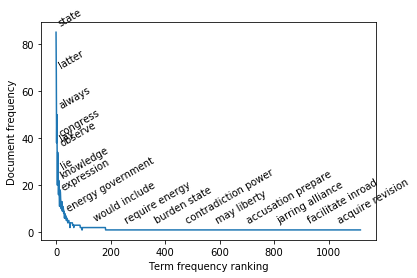

In [11]:
# visualisation of ZIPF law
def visualise_zipf(terms, itr_step = 50):
    from scipy.spatial.distance import euclidean
    from math import sqrt
    
    # --- Param ---
    # terms: collection of terms dictionary from calculate_tf_idf_terms function
    # itr_step: used to control how many terms that you want to plot. Num of terms to plot = N terms / itr_step
    
    # sort terms by its frequency
    terms.sort(key=lambda x: (x['tf'], x['df']), reverse=True)
    
    # select a few of the terms for plotting purpose
    sel_terms = [terms[i] for i in range(0, len(terms), itr_step)]
    labels = [term['term'] for term in sel_terms]
    
    # plot term frequency ranking vs its DF
    plt.plot(range(len(sel_terms)), [x['df'] for x in sel_terms])
    plt.xlabel('Term frequency ranking')
    plt.ylabel('Document frequency')
    
    max_x = len(sel_terms)
    max_y = max([x['df'] for x in sel_terms])
    
    # annotate the points
    prev_x, prev_y = 0, 0
    for label, x, y in zip(labels,range(len(sel_terms)), [x['df'] for x in sel_terms]):
        # calculate the relative distance between labels to increase visibility
        x_dist = (abs(x - prev_x) / float(max_x)) ** 2
        y_dist = (abs(y - prev_y) / float(max_y)) ** 2
        scaled_dist = sqrt(x_dist + y_dist)
        
        if (scaled_dist > 0.1):
            plt.text(x+2, y+2, label, {'ha': 'left', 'va': 'bottom'}, rotation=30)
            prev_x, prev_y = x, y
    
    plt.show()
    
visualise_zipf(terms)

Zipf's law is applied in text mining during the feature selection process. Terms that occured on the left-top area of the diagram above (e.g. state and latter) are terms that are too frequent (high TF and DF). Meanwhile, terms on the right-bottom side of the diagram e.g. ("acquire revision" and "facilitate
inroad") only appear in select number of documents. Both groups of terms do not add value, thus filtering the low and high end terms, and keeping only terms in the middle area will benefit a clustering solution. This filtering can easily be done through limiting the DF value of terms in vectoriser.

In [12]:
# another tf idf vectoriser
# limit the terms produced to terms that occured in min of 2 documents and max 80% of all documents
filter_vec = TfidfVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2), min_df=2, max_df=0.8)
X_filter = filter_vec.fit_transform(df['Text'])

# see the number of unique tokens produced by the vectorizer. Reduced!
print(len(filter_vec.get_feature_names()))

8938


This process greatly reduced the number of terms in a feature set. Try to build another clustering solution and check if the clusters are more meaningful.

In [13]:
%%time
# K means clustering using the new term vector, time it for comparison to SVD
kmeans_fil = KMeans(n_clusters=7, random_state=rs).fit(X_filter)

Wall time: 749 ms


In [14]:
# visualisation
visualise_text_cluster(kmeans_fil.n_clusters, kmeans_fil.cluster_centers_, filter_vec.get_feature_names())

Top terms for cluster 0: election, representative, knowledge, legislature, law, 
Top terms for cluster 1: convention, national, authority, form, republican, 
Top terms for cluster 2: upon, army, nation, national, militia, 
Top terms for cluster 3: representative, number, senate, interest, member, 
Top terms for cluster 4: president, senate, office, appointment, upon, 
Top terms for cluster 5: court, law, jurisdiction, authority, clause, 
Top terms for cluster 6: department, legislative, judiciary, legislative department, judiciary department, 


With much less terms in the feature vector, the clustering process managed to
result in much more meaningful solution. The cluster topics can be distinctly
recognized like justice department (\#6), military (\#2), parliament (\#3), etc.

### 4.2. Singular Value Decomposition

Singular value decomposition (SVD) is a dimensionality reduction method that
works by factorizing a matrix. SVD is used widely in data mining through many techniques like Principal Component Analysis (PCA - a common dimensionality reduction method applied on traditional data to understand variables dependencies) and in text mining, Latent Semantic Analysis (LSA). LSA is
applied to analyzing documents by finding the underlying meaning or concepts of words in these documents. LSA uses SVD to reduce the number of terms while
preserving the similarity structure among documents.

[More info](https://en.wikipedia.org/wiki/Latent_semantic_analysis)

LSA is typically used to help comparing and finding similar documents (like in document clustering and classification) and also finding synonymous/polysemous relationships between words. LSA can help in increasing speed (less features) and accuracy (comparison is now based on document concept similary instead of word similarity) of the model.

In the following code, we will reduce the original `X` into only 100 components.

In [15]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100, random_state=42)
X_trans = svd.fit_transform(X_filter)

Each of the components produced by SVD contain weights associated with each word. The larger the weight is, the more connected the word is to the component.

In [16]:
# sort the components by largest weighted word
sorted_comp = svd.components_.argsort()[:, ::-1]
terms = filter_vec.get_feature_names()

# visualise word - concept/component relationships
for comp_num in range(10):
    print("Top terms in component #{}".format(comp_num), end=" ")
    for i in sorted_comp[comp_num, :5]:
        print(terms[i], end=", ")
    print()

Top terms in component #0 upon, national, law, authority, representative, 
Top terms in component #1 senate, president, representative, legislative, department, 
Top terms in component #2 court, law, jurisdiction, judiciary, department, 
Top terms in component #3 president, senate, upon, treaty, appointment, 
Top terms in component #4 department, legislative, army, judiciary, republic, 
Top terms in component #5 court, treaty, cause, jurisdiction, nation, 
Top terms in component #6 interest, upon, taxation, revenue, merchant, 
Top terms in component #7 confederation, treaty, congress, article, clause, 
Top terms in component #8 amendment, republican, convention, plan, majority, 
Top terms in component #9 member, authority, state government, city, militia, 


The transformed `X` can now be used for clustering. Build a new clustering solution on the transformed `X`.

In [17]:
%%time
# K-means clustering using LSA-transformed X
svd_kmeans = KMeans(n_clusters=7, random_state=rs).fit(X_trans)

Wall time: 31.2 ms


SVD transformed clustering is much much faster than the normal one (~50 ms vs ~800 ms). Let's see if the SVD transformation changes the clustering characteristics.

In [18]:
# transform cluster centers back to original feature space for visualisation
original_space_centroids = svd.inverse_transform(svd_kmeans.cluster_centers_)

# visualisation
visualise_text_cluster(svd_kmeans.n_clusters, original_space_centroids, filter_vec.get_feature_names())

Top terms for cluster 0: election, representative, knowledge, legislature, law, 
Top terms for cluster 1: convention, national, authority, form, republican, 
Top terms for cluster 2: upon, army, nation, national, militia, 
Top terms for cluster 3: representative, number, senate, interest, member, 
Top terms for cluster 4: president, senate, office, appointment, upon, 
Top terms for cluster 5: court, law, jurisdiction, authority, clause, 
Top terms for cluster 6: department, legislative, judiciary, legislative department, judiciary department, 


There is not much difference in the cluster topic terms between SVD-transformed feature vs normal feature. This means the original clustering solution has managed to capture the difference in concepts/topics in the document space. SVD is still beneficial due to reduced training time, which is extremely beneficial in large document clustering.

## End Notes

This practical gives you a tour to familiarize with text mining functions and libraries in Python, and how a data set appearing in the text format can be analyzed with data mining techniques such as clustering. You prepared the FEDPAPERS data set for finding the natural groupings of the text data. It particularly covered text pre-processing (such as stop-word removal, lemmatizing), dimensionality reduction (applying Zipf’s law and transformation of the text data with a factorization method (for feature selection) called as Singular Value Decomposition (SVD)), and finally performing clustering on the text data for finding similarity and understanding the common themes in the data set.